In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd

In [19]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [21]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [26]:
# Create inspect object for hawaii.sqlite
inspector = inspect(engine)

In [27]:
# Get a list of column names and types for measurement
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [28]:
# Get a list of column names and types for measurement
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# 2017-08-23 is the latest available from the dataset...
precipitation_12months = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    group_by(Measurement.date).all()

In [44]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_12months, columns=['date', 'precipitation'])
precipitation_df = precipitation_df.set_index('date')
precipitation_df.head(10)

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000


In [47]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df.head(10)

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000


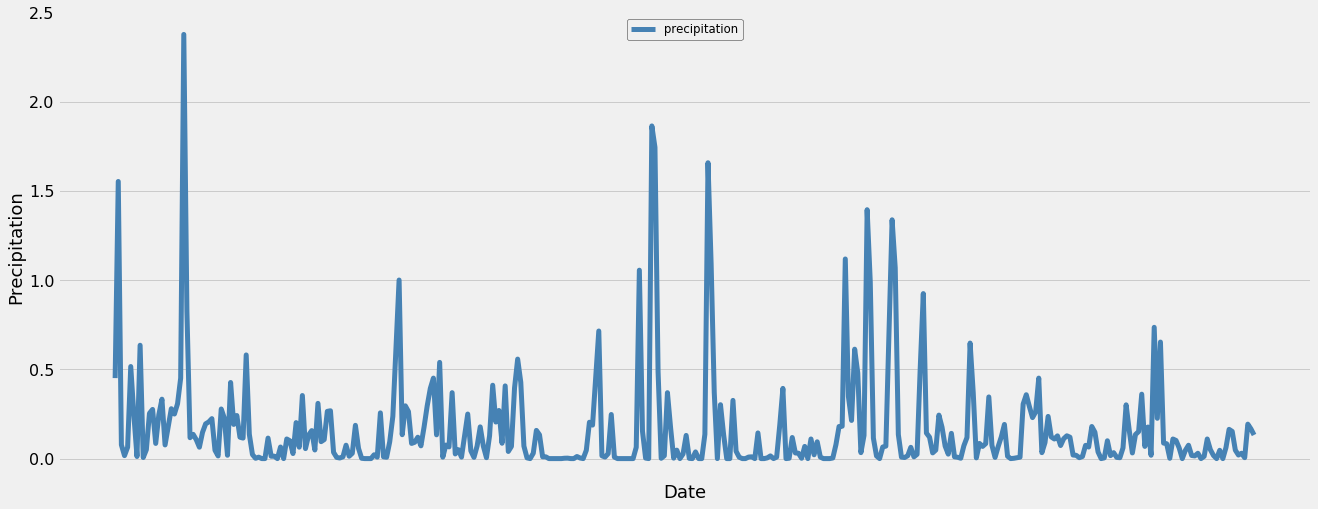

In [66]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=[20, 8])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Precipitation", fontsize=18)
plt.tick_params(axis='y', labelsize=16)
plt.xticks([])

plt.plot(precipitation_df.index.values, precipitation_df['precipitation'], color='steelblue', linewidth=5)
plt.legend(['precipitation'], loc='upper center', fontsize='small', frameon=True, edgecolor='black')



plt.show()

In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [72]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
station_count = session.query(func.count(distinct(Station.station))).first()
station_count

(9)

In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_desc = session.query(Measurement.station, func.count(Measurement.id)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.


# Transform query result to dataframe
station_desc_df = pd.DataFrame(data=station_desc, columns=['Station', 'Count'])
station_desc_df.head(10)

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_tobs = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs)\
                           , func.avg(Measurement.tobs)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_tobs

(54.0, 85.0, 71.66378066378067)

In [87]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_observations = session.query(Measurement.tobs).\
        filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
        filter(Measurement.station == station_desc_df['Station'][0]).all()

#Transform query result to dataframe
most_active_station_observations_df = pd.DataFrame(data=most_active_station_observations, columns=['tobs'])
most_active_station_observations_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


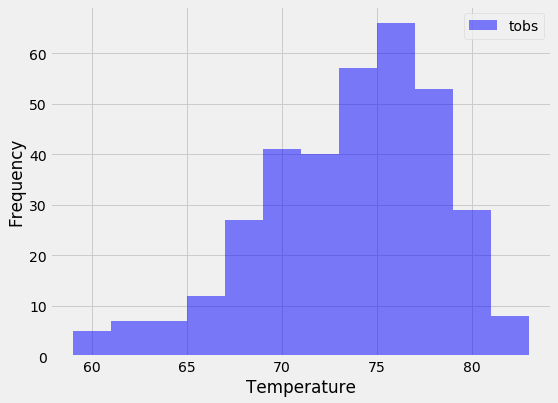

In [94]:
#plot result as histogram
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(most_active_station_observations_df['tobs'], bins=12, color='blue', alpha=0.5)
ax.legend(['tobs'])

ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.show()

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [96]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


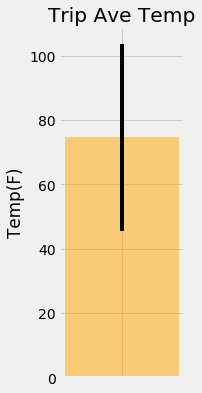

In [117]:
# Plot the results from your previous query as a bar chart. 
temps_bar_df = pd.DataFrame(data=calc_temps('2016-08-23', '2017-08-23'), columns=['min', 'avg', 'max'])

temps_min = temps_bar_df['min']
temps_max = temps_bar_df['max']
temps_avg = temps_bar_df['avg']

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,6))
plt.bar(1,height = temps_avg,width = 0.1,linewidth=10,alpha=0.5, tick_label="", color="orange"\
        ,yerr=temps_max-temps_min)

# Use "Trip Avg Temp" as your Title
plt.title("Trip Ave Temp")
plt.ylabel("Temp(F)")
plt.show()

In [127]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude\
                                 , Station.elevation, func.sum(Measurement.prcp)).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
                group_by(Station.station, Station.name, Station.latitude, Station.longitude\
                                 , Station.elevation).order_by(func.sum(Measurement.prcp).desc()).all()
station_rainfall_df = pd.DataFrame(data = station_rainfall, columns=['station', 'name', 'latitude'\
                                                                     , 'longitude', 'elevation', 'total rainfall'])
station_rainfall_df.head()

,station,name,latitude,longitude,elevation,total rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


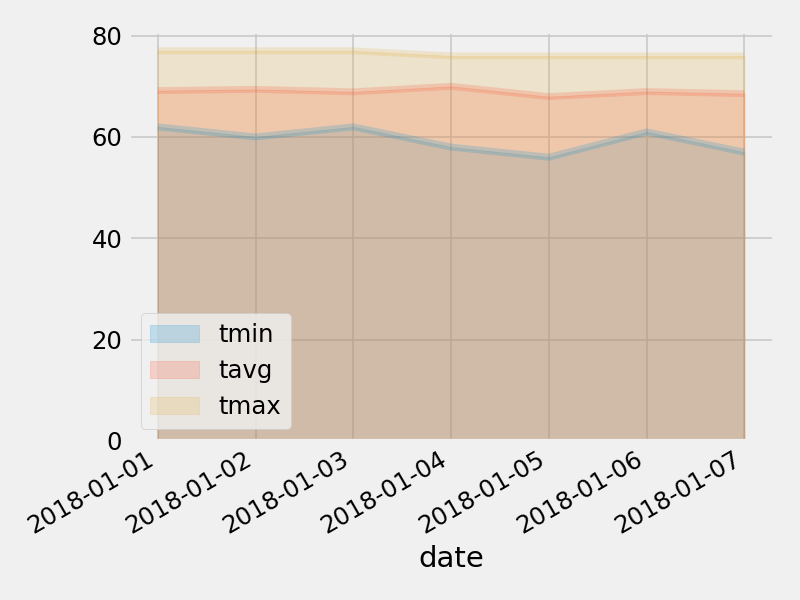

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
